Today, let us revisit a very classic problem in Probabilities.

-  The **Taxi Problem** ( same problem is also called the German Tank Problem)
    -  Basically, you are visiting a new city
    -  You see that each taxi have a serial number
    -  You take three taxis during your first day
        -  Serial 215, 421, 596
    - Based on this information, estimate how many taxis are in this city?
    
To solve this problem, we are going to use three solutions:
-  A classic frequentist approach
-  A Bayesian approach - we will build and run a simulation
-  A Bayesian approach - we will use the package pymc3 to run a simulation
-  A Bayesian approach - we will calculate the exact probabilities

In [1]:
import numpy as np
import random
import itertools

In [2]:
taxis_serial = [314, 421, 596]

### 1. Frequentist Approach

The main idea is to get an estimate of the average spacing between samples:
-  N is the estimate for the largest member of the population (i.e. the number of taxis).
-  M is the maximum sample from the sample set.
-  m is the minimum sample from the sample set.
-  k is the number of samples in the sample set.

Number of taxis in the city:
-  M + (M-m) / k


In [3]:
def freq_methods(taxis_list):
    k = len(taxis_list)
    if k < 2:
        raise ValueError(" Formula valid for len(captured_tanks) >= 2.".format(k))
    
    M = np.max(taxis_list)
    m = np.min(taxis_list)
    
    return M + (M-m)/k

In [4]:
freq_methods(taxis_serial)

690.0

### I. Bayesian Approach - Simulation 1

Let us consider we know how many taxis are in the city:
-  We pick three taxis randomly
-  What is the probability that they have the same serials number than the our data?

We repeat the same process for different value for the total number of taxis in the city. 

In [53]:
# Function used to run the simulation
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

# Let us define the number of cars randomly between max serial number and 3000
def prior_ntaxis_sampler(taxis_list, upper=2000):
    '''Yield random integers in the range (max(taxis_list), upper).'''
    while True:
        yield random.randint(max(taxis_list), upper)

# Once we have defined n_taxis as the total number of taxis, let us pick n_observed serial number
def simulate_taxis(n_taxis, n_observed):
    '''Return serial numbers of n_observed taxis given there are a total of n_taxis.'''
    return random.sample(range(n_taxis), n_observed)

# We compare to see if the observation are within the same range 
# => would mean that n-taxis is a good estimator of the true number of taxis 
def compare_taxis(obs1, obs2, tol=20):
    '''Return True if two sets of serial numbers agree within a tolerance.'''
    return all(abs(o1 - o2) <= tol 
               for o1, o2 in zip(sorted(obs1), sorted(obs2)))

# Let us wrap it up a nice and friendly function:
def bayes_1(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p

In [54]:
post_ntaxis_sampler = bayes_1( taxis_serial,
                                prior_ntaxis_sampler(taxis_serial),
                                lambda n_taxis: simulate_taxis(n_taxis, len(taxis_serial)),
                                compare_taxis)

taxis_samples = take(1000, post_ntaxis_sampler)

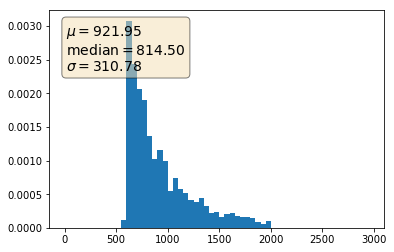

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1)

mu = np.mean(taxis_samples)
median = np.median(taxis_samples)
sigma = np.std(taxis_samples)
textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mu, median, sigma)

ax.hist(taxis_samples, normed=True, bins=taxis_bins)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

### II. Bayesian Approach

In [59]:
import pymc3 as pm 

with pm.Model():
    n_taxi = pm.DiscreteUniform('n_taxi', lower=max(taxis_serial), upper=2000)
    obs = pm.DiscreteUniform('obs', lower=0, upper=n_taxi, observed=taxis_serial) 
    trace = pm.sample(10000)

Assigned Metropolis to n_taxi
100%|██████████| 10500/10500 [00:02<00:00, 4263.52it/s]


In [60]:
pm.summary(trace)


n_taxi:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  924.112          321.359          14.660           [596.000, 1647.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  600.000        677.000        817.000        1072.000       1813.000



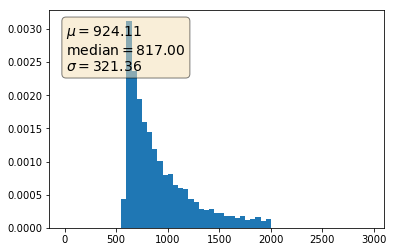

In [70]:
fig, ax = plt.subplots(1)

mu = np.mean(trace['n_taxi'])
median = np.median(trace['n_taxi'])
sigma = np.std(trace['n_taxi'])

ax.hist(trace['n_taxi'], normed=True, bins=taxis_bins)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

In [82]:
binom(499,2)

124251

In [71]:
from math import factorial

def binom(x, y):
    '''Return binomial coefficient for x, y.'''
    return factorial(x)//(factorial(y) * factorial(x - y))

def analytic_solution(n_tanks, captured_tanks):
    '''Probability that there are n_tanks given a list of captured serial numbers.'''
    k = len(captured_tanks)
    if k < 2:
        raise ValueError("Analytic formula valid for len(captured_tanks) >= 2.".format(k))
    m = max(captured_tanks)
    if n_tanks < m:
        return 0.0
    else:
        return (k - 1)/k * binom(m - 1, k - 1)/binom(n_tanks, k)

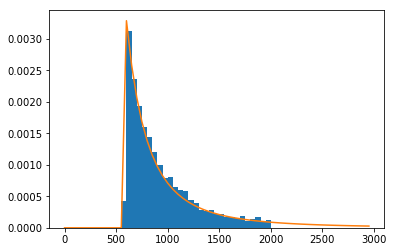

In [78]:
plt.hist(trace['n_taxi'], normed=True, bins=taxis_bins);
plt.plot(taxis_bins, [analytic_solution(x, taxis_serial) for x in taxis_bins]);